Make all the plots for our paper -- mod the ones from variability analysis

In [1]:
import numpy as np
import pandas as pd
from astropy.cosmology import FlatLambdaCDM
from scipy.stats import norm
import matplotlib.pyplot as plt
import matplotlib
import richardsplot as rplot
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True
prop_cycle = plt.rcParams['axes.prop_cycle']
mplcolors = prop_cycle.by_key()['color']

/Users/trevormccaffrey/anaconda3/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


In [2]:
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

def radluminosity(nu1, nu2, S_nu2, alpha, z):
    #calculate luminosity at nu1 based on data at nu2
    #input flux density units are µJy
    DL = 3.086e24*cosmo.luminosity_distance(z).value
    L = ((4*np.pi*DL**2*(S_nu2*1e-23*1e-6)) / ((1+z)**(1+alpha))) * (nu1/nu2)**alpha * 1e-7
    return np.log10(L)

def LtoS(nu1, nu2, L_nu2, alpha, z):
    #Compute flux at nu2 given log L at nu1
    DL = 3.086e24*cosmo.luminosity_distance(z).value
    L = 10**L_nu2
    S = L * (((1+z)**(1+alpha))/(4*np.pi*DL**2)) * 1e36 * (nu2/nu1)**alpha
    return S

def isNAN(arr):
    #this isnan works for strings too; np.isnan(a) only works if all elements
    #is arr are floats
    return arr!=arr

def S2N_err(S2N):
    #specific for this notebook
    #given a S2N detection threshold, compute the corresponding error on log S_A/S_C
    return np.sqrt( 2 * ( 1 / (S2N*np.log(10))**2 ) )

In [3]:
S2N_err(3)

0.20472838212379177

In [4]:
radluminosity(6., 6., 100, -0.7, .243)

22.222518348151933

In [5]:
df = pd.read_csv("RQQfigs.csv")

sdss_names = df[["Name"]].values.flatten()
S6         = df[["Flux"]].values.flatten()
det        = df[["Detection"]].values.flatten()==1
z          = df[["z"]].values.flatten()
vlba       = df[["VLBA"]].values.flatten()==1
#L6        = L_6(z, S6, -0.7)
L6         = radluminosity(6., 6., S6, -0.7, z)
mi         = df[["i"]].values.flatten().astype("float")
Si         = 10**((9.56-mi/2.5))
logR       = np.log10(S6/Si)

S6_kell    = df[["S(6)_t"]].values.flatten()
L6_kell    = radluminosity(6., 6., S6_kell, -0.7, z)

log_ratio = np.log10(S6/S6_kell)
log_ratio.shape

(128,)

In [6]:
A_morph = df[["A_morph"]].values.flatten()
U  = (A_morph=="U")  #unresolved
SR = (A_morph=="SR") #slightly resolved
M  = (A_morph=="M")  #muliple (>=2) component
D  = (A_morph=="D")  #double lobe, no core
E  = (A_morph=="E")  #asymmetric (basically all the more complicated ones for now)
ND = (A_morph=="ND") #non-detection

print("Morphology number counts for all RQQs\n")

print("Unresolved        : %d" % U.sum())
print("Resolved          : %d\n" % ((~U).sum()-(isNAN(A_morph).sum())-ND.sum()))
print("Slightly resolved : %d" % SR.sum())
print("Multi-component   : %d" % M.sum())
print("Double lobe       : %d" % D.sum())
print("Extended          : %d" % E.sum())
print("Non-detections    : %d" % ND.sum())

Morphology number counts for all RQQs

Unresolved        : 67
Resolved          : 55

Slightly resolved : 31
Multi-component   : 16
Double lobe       : 1
Extended          : 7
Non-detections    : 6


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


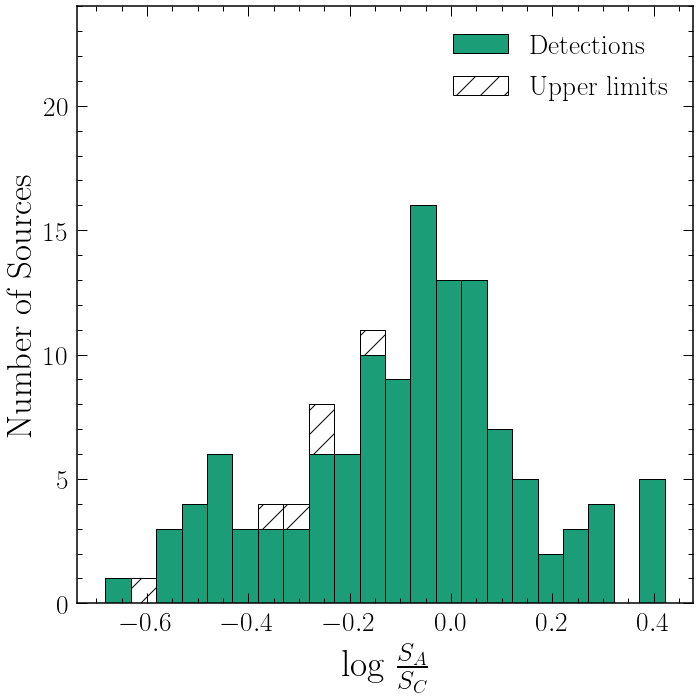

Ratio stats (converted to linear):

Median: 0.86
Mean  : 0.80
Std   : 1.72


In [7]:
ratbins = np.linspace(min(log_ratio), max(log_ratio), 23)

fig = plt.figure(figsize=(10,10))

ax1 = plt.subplot(111)

n, bins, patches = ax1.hist([log_ratio[~ND],log_ratio[ND]], histtype="barstacked", 
                   edgecolor="k", color=[rplot.csdark[0], "w"], bins=ratbins, 
                   label=["Detections","Upper limits"])

#Need to do hatches manually since matplotlib doesn't
#let you separate them for separate data series
hatches = ['', '/']
for patch_set, hatch in zip(patches, hatches):
    for patch in patch_set.patches:
        patch.set_hatch(hatch)
ax1.set_xlabel("log $\\frac{S_A}{S_C}$", fontsize=37.5)
ax1.set_ylabel("Number of Sources", fontsize=35)
ax1.set_ylim(0,24.0)
ax1.legend(loc="best", prop={"size":27.5}, frameon=False)
ax1.tick_params(axis='both', which='major', labelsize=27.5)
plt.tight_layout()
plt.savefig("PaperPlots/totalfluxratiohist.pdf")
plt.show()

median = 10.**np.median(log_ratio)
mean   = 10.**np.mean(log_ratio)
std    = 10.**np.std(log_ratio)
print("Ratio stats (converted to linear):\n")
print("Median: {:.2f}".format(median))
print("Mean  : {:.2f}".format(mean))
print("Std   : {:.2f}".format(std))

We know there's a leftward skew, but how many of the bigger decreases in flux density are due strictly to resolution effects (and thus possibly SF) rather than variability (which is easily attributable to the larger *increases* in flux density)?


To test this:

1. Clip the true distribution
2. Gaussian fit the clipped distribution to get a sigma that isn't as overweighted by the outliers
3. How many from the true distribution are below/above a $0\pm\sigma$ cutoff from the clipped fit?

In [8]:
from astropy.stats import sigma_clip
ratio_clip = sigma_clip(log_ratio,sigma_lower=3,sigma_upper=2.,maxiters=10,masked=False)
print(len(ratio_clip))
print(np.mean(log_ratio),np.mean(ratio_clip))
print(np.std(log_ratio),np.std(ratio_clip))
print(np.max(log_ratio),np.max(ratio_clip))
print(np.min(log_ratio),np.min(ratio_clip))

126
-0.09520047815980433 -0.10329844578758315
0.23464014811117603 0.2274472280779529
0.42174932174293434 0.3874745749938726
-0.6821565053263687 -0.6821565053263687


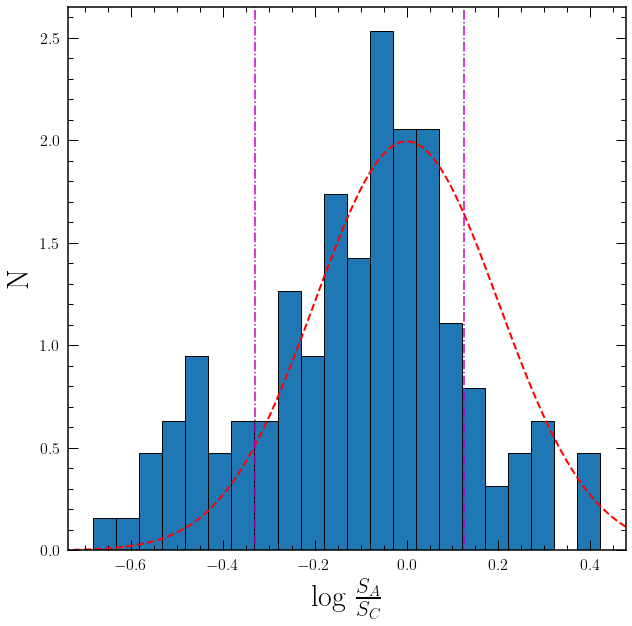

In [9]:
fitbins = np.linspace(min(log_ratio)-1, max(log_ratio)+1, 500)

fig = plt.figure(figsize=(10,10))

plt.hist(ratio_clip, histtype="barstacked", edgecolor="k",bins=ratbins,density=True)

# best fit of (clipped) data
# This gives the true median and sigma
(mu, sigma) = norm.fit(ratio_clip)
median = np.median(ratio_clip)
y = norm.pdf(fitbins, 0, 0.2) #ignore last bin to match shape of n
#y_true = (y*len(fnvss_clip)*0.1) #get rid of normalization - 0.1 is bin width

xlims = plt.gca().get_xlim()
plt.plot(fitbins, y, 'r--', linewidth=2)
plt.plot([mu-sigma,mu-sigma], [-.2,3.0], "-.m")
plt.plot([mu+sigma,mu+sigma], [-.2,3.0], "-.m")

plt.xlabel("log $\\frac{S_A}{S_C}$", fontsize=30)
plt.ylabel("N", fontsize=30)
plt.ylim(0,2.65)
plt.xlim(xlims)
plt.show()

Now want to ask how many from the *original* distribution are below $-\sigma$ and above $+\sigma$?

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


Source counts above/below 1-sigma from the mean

Above: 12
Below: 35

So there are at least 35-12= 23 sources with significant resolved out emission
23/124=18.55%


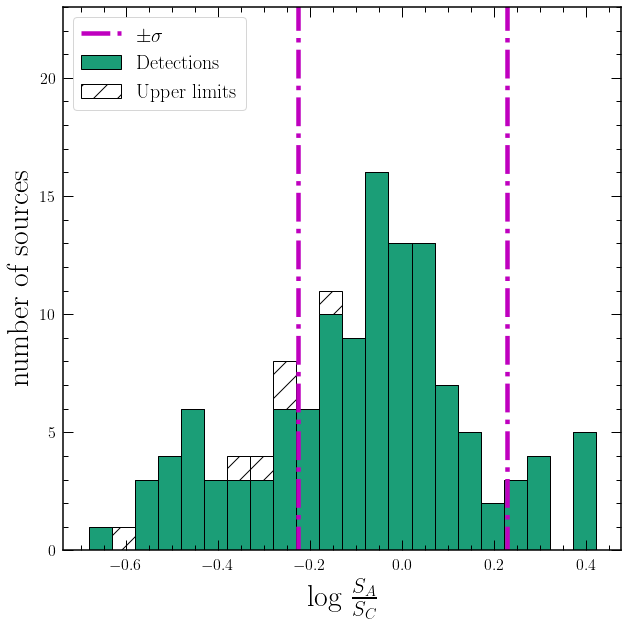

In [10]:
fig = plt.figure(figsize=(10,10))

ax1 = plt.subplot(111)

n, bins, patches = ax1.hist([log_ratio[~ND],log_ratio[ND]], histtype="barstacked", 
                   edgecolor="k", color=[rplot.csdark[0], "w"], bins=ratbins, 
                   label=["Detections","Upper limits"])

#Need to do hatches manually since matplotlib doesn't
#let you separate them for separate data series
hatches = ['', '/']
for patch_set, hatch in zip(patches, hatches):
    for patch in patch_set.patches:
        patch.set_hatch(hatch)

ax1.plot([-sigma,-sigma], [-.2,33.0], "-.m", linewidth=4.5, label="$\pm\sigma$")
ax1.plot([+sigma,+sigma], [-.2,33.0], "-.m", linewidth=4.5)

#ax1.annotate('', xy=(0.385, 19.9), xytext=(-35, 0), textcoords='offset points', 
#                arrowprops=dict(facecolor='m', shrink=0.05))
#ax1.annotate('', xy=(0.385, 22.7), xytext=(-35, 0), textcoords='offset points', 
#                arrowprops=dict(facecolor='m', shrink=0.05))
#ax1.annotate('', xy=(0.385, 25.4), xytext=(-35, 0), textcoords='offset points', 
#                arrowprops=dict(facecolor='m', shrink=0.05))



ax1.set_xlabel("log $\\frac{S_A}{S_C}$", fontsize=30)
ax1.set_ylabel("number of sources", fontsize=30)
ax1.set_ylim(0,23.0)
ax1.legend(loc="best", prop={"size":20})

#Define a notable change in flux to be ±sigma 
over = (log_ratio>(0.+1.0*sigma))
under= (log_ratio<(0.-1.0*sigma))

print("Source counts above/below 1-sigma from the mean\n")
print("Above: {}".format(over.sum()))
print("Below: {}\n".format(under.sum()))
print("So there are at least {}-{}= {} sources with significant resolved out emission".format(under.sum(),over.sum(),(under.sum()-over.sum())))
print("{}/124={:.2f}%".format((under.sum()-over.sum()), 100*(under.sum()-over.sum())/124))

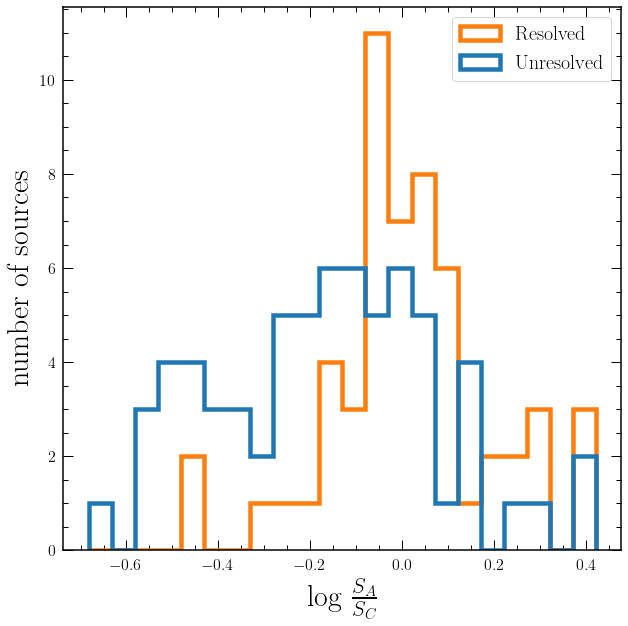

(0.7027272727272728, 1.01496062992126)

In [11]:
fig = plt.figure(figsize=(10,10))

plt.hist([log_ratio[U], log_ratio[(~U)&(~ND)]], bins=ratbins, histtype="step", 
          linewidth=4.5, label=["Unresolved", "Resolved"])

plt.xlabel("log $\\frac{S_A}{S_C}$", fontsize=30)
plt.ylabel("number of sources", fontsize=30)
plt.legend(loc="best", prop={"size":20})
plt.show()

10.**np.median(log_ratio[U]), 10.**np.median(log_ratio[(~U)&(~ND)])

Make this an inset of the first figure

Compute the errors on the flux ratio.

$$ (\frac{\delta{X}}{X})^2 = (\frac{\delta{S_A}}{S_A})^2 + (\frac{\delta{S_C}}{S_C})^2 $$

$$ \rightarrow \delta({\frac{S_A}{S_C}}) = \frac{S_A}{S_C} * \sqrt{\frac{\delta{S_A}}{S_A})^2 + (\frac{\delta{S_C}}{S_C})^2} $$

These can also be converted to log like so:

$$ \delta (\log{S}) = \frac{\delta(S)}{S \ln{10}} $$

$$ \log \frac{S_A}{S_C} = \log S_A - \log S_C $$\

$$ \rightarrow \delta(\log \frac{S_A}{S_C}) = \sqrt{(\frac{\delta(S_A)}{S_A \ln{10}})^2 + (\frac{\delta(S_C)}{S_C \ln{10}})^2} $$

In [12]:
#Need Ours/Ken's errors to get errors of the ratio
Aerr = df[["FluxErr"]].values.flatten()
Cerr = df[["pmt"]].values.flatten()
ratio= 10.**log_ratio

ratioerr = ratio*np.sqrt((Aerr/S6)**2. + (Cerr/S6_kell)**2.)

log_err = np.sqrt( (Aerr/(S6*np.log(10)))**2 + (Cerr/(S6_kell*np.log(10)))**2 )
mederrU = np.median(log_err[U])
mederrR = np.median(log_err[(~U)&(~ND)])
mederrU, mederrR

(0.06805122698981109, 0.0652130775132646)

/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


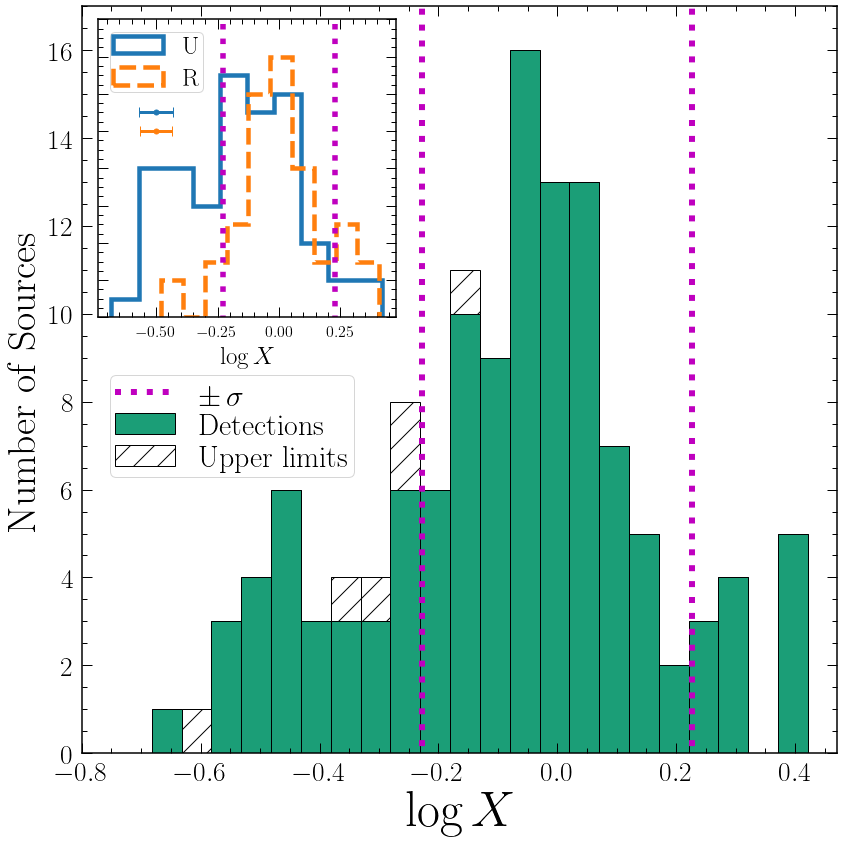

In [13]:
fig, ax1 = plt.subplots(figsize=(12,12))

n, bins, patches = ax1.hist([log_ratio[~ND],log_ratio[ND]], histtype="barstacked", 
                   edgecolor="k", color=[rplot.csdark[0], "w"], bins=ratbins, 
                   label=["Detections","Upper limits"])

#Need to do hatches manually since matplotlib doesn't
#let you separate them for separate data series
hatches = ['', '/']
for patch_set, hatch in zip(patches, hatches):
    for patch in patch_set.patches:
        patch.set_hatch(hatch)

ax1.plot([-sigma,-sigma], [-.2,33.0], ":m", linewidth=6.0, label="$\pm$\,$\sigma$")
ax1.plot([+sigma,+sigma], [-.2,33.0], ":m", linewidth=6.0)

ax1.set_xlabel("log\,$X$", fontsize=50)
ax1.set_ylabel("Number of Sources", fontsize=40)
ax1.tick_params(axis='both', which='major', labelsize=27.5)
ax1.set_ylim(0,17.0)
ax1.set_xlim(-0.8, 0.47)
ax1.legend(bbox_to_anchor=(0.38,0.35), prop={"size":30},frameon=True, 
           borderpad=0.15,labelspacing=0.1)



# These are in unitless percentages of the figure size. (0,0 is bottom left)
left, bottom, width, height = [0.125, 0.62, 0.345, 0.345]
ax2 = fig.add_axes([left, bottom, width, height])

labels = [item.get_text() for item in ax2.get_yticklabels()]
empty_string_labels = ['']*len(labels)
ax2.set_yticklabels(empty_string_labels)

ax2.hist(log_ratio[U], histtype="step", linewidth=4.5, 
         ls="-", label="U")
ax2.hist(log_ratio[(~U)&(~ND)], histtype="step", 
          linewidth=4.5, label="R", ls="--")

ax2.plot([-sigma,-sigma], [-.2,33.0], ":m", linewidth=5.5)
ax2.plot([+sigma,+sigma], [-.2,33.0], ":m", linewidth=5.5)

#Add exemplary error bars
ax2.errorbar(x=-0.50, y=11.0, xerr=mederrU, markersize=5, capsize=4.9, fmt="o", linewidth=3.0, color=mplcolors[0])
ax2.errorbar(x=-0.50, y=10.0, xerr=mederrR, markersize=5, capsize=4.9, fmt="o", linewidth=3.0, color=mplcolors[1])

ax2.set_xlabel("log\,$X$", fontsize=25)
#ax2.set_ylabel("number of sources", fontsize=30)
ax2.legend(loc="upper left", prop={"size":25}, borderpad=0.1,labelspacing=0.3)
ax2.set_ylim(0,16)

plt.tight_layout()
#plt.savefig("PaperPlots/fluxratio_wresolveinset.pdf")
plt.show()

/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in true_divide
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


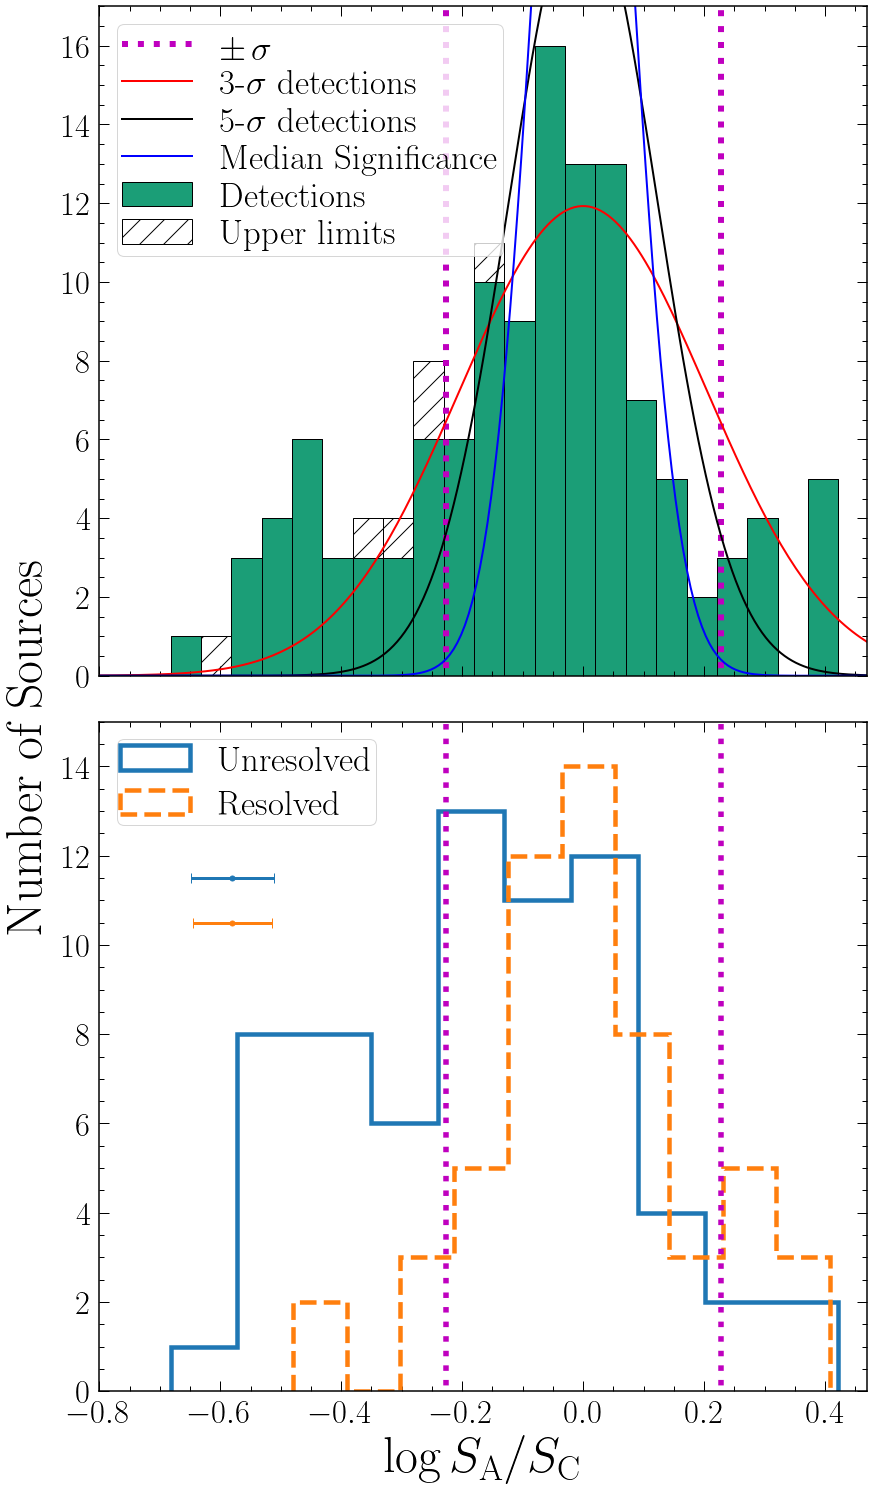

In [14]:
ratbins = np.linspace(min(log_ratio), max(log_ratio), 23)

from matplotlib.transforms import Bbox

fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(12,21), sharex=True)

n, bins, patches = ax1.hist([log_ratio[~ND],log_ratio[ND]], histtype="barstacked", 
                   edgecolor="k", color=[rplot.csdark[0], "w"], bins=ratbins, 
                   label=["Detections","Upper limits"])

#Need to do hatches manually since matplotlib doesn't
#let you separate them for separate data series
hatches = ['', '/']
for patch_set, hatch in zip(patches, hatches):
    for patch in patch_set.patches:
        patch.set_hatch(hatch)

ax1.plot([-sigma,-sigma], [-.2,33.0], ":m", linewidth=6.0, label="$\pm$\,$\sigma$")
ax1.plot([+sigma,+sigma], [-.2,33.0], ":m", linewidth=6.0)

#ax1.set_xlabel("log\,$X$", fontsize=50)
#ax1.set_ylabel("Number of Sources", fontsize=40)
ax1.tick_params(axis='both', which='major', labelsize=32.5)
ax1.set_ylim(0,17.)
xlims = plt.gca().get_xlim()

y0 = norm.pdf(fitbins, 0, S2N_err(3))*len(log_ratio[~ND])*(ratbins[1]-ratbins[0]) 
y1 = norm.pdf(fitbins, 0, S2N_err(5))*len(log_ratio[~ND])*(ratbins[1]-ratbins[0]) 
y2 = norm.pdf(fitbins, 0, S2N_err(np.median(S6[~ND]/Aerr[~ND])))*len(log_ratio[~ND])*(ratbins[1]-ratbins[0])
ax1.plot(fitbins, y0, 'r-', linewidth=2, label="3-$\sigma$ detections")
ax1.plot(fitbins, y1, 'k-', linewidth=2, label="5-$\sigma$ detections")
ax1.plot(fitbins, y2, 'b-', linewidth=2, label="Median Significance")
ax1.set_xlim(-0.8, 0.47)
ax1.legend(loc="upper left", prop={"size":35},frameon=True, 
           borderpad=0.15,labelspacing=0.1)


ax2.hist(log_ratio[U], histtype="step", linewidth=4.5, 
         ls="-", label="Unresolved")
ax2.hist(log_ratio[(~U)&(~ND)], histtype="step", 
          linewidth=4.5, label="Resolved", ls="--")

ax2.plot([-sigma,-sigma], [-.2,33.0], ":m", linewidth=5.5)
ax2.plot([+sigma,+sigma], [-.2,33.0], ":m", linewidth=5.5)

#Add exemplary error bars
ax2.errorbar(x=-0.58, y=11.5, xerr=mederrU, markersize=5, capsize=4.9, fmt="o", linewidth=3.0, color=mplcolors[0])
ax2.errorbar(x=-0.58, y=10.5, xerr=mederrR, markersize=5, capsize=4.9, fmt="o", linewidth=3.0, color=mplcolors[1])

ax2.set_xlabel("log\,$S_\mathrm{A}/S_\mathrm{C}$", fontsize=50)
#ax2.set_ylabel("number of sources", fontsize=30)
ax2.tick_params(axis='both', which='major', labelsize=32.5)
ax2.legend(loc="upper left", prop={"size":35}, borderpad=0.1,labelspacing=0.3)
ax2.set_ylim(0,15)


#Add common y-label
fig.text(0.01, 0.5, 'Number of Sources', ha='center', va='center', rotation='vertical', fontsize=50)

plt.tight_layout()
#plt.savefig("PaperPlots/fluxratio_wresolveinset.pdf", bbox_inches=Bbox([[-0.5,0],[14,21]]))
plt.show()

Compute medians and their errors.  Error on median should be roughly 25% higher than standard error which is $\sigma/\sqrt{N}$

In [15]:
np.median(log_ratio[(~U)&(~ND)]), 1.25*np.std(log_ratio[(~U)&(~ND)])/np.sqrt(len(log_ratio[(~U)&(~ND)]))

(0.006449196397446186, 0.030734510184860557)

In [16]:
np.median(log_ratio[U]), 1.25*np.std(log_ratio[U])/np.sqrt(len(log_ratio[U]))

(-0.15321319123990013, 0.03628042733215816)

In [17]:
np.median(log_ratio), 1.25*np.std(log_ratio)/np.sqrt(len(log_ratio))

(-0.06640942046502904, 0.025924318729379444)

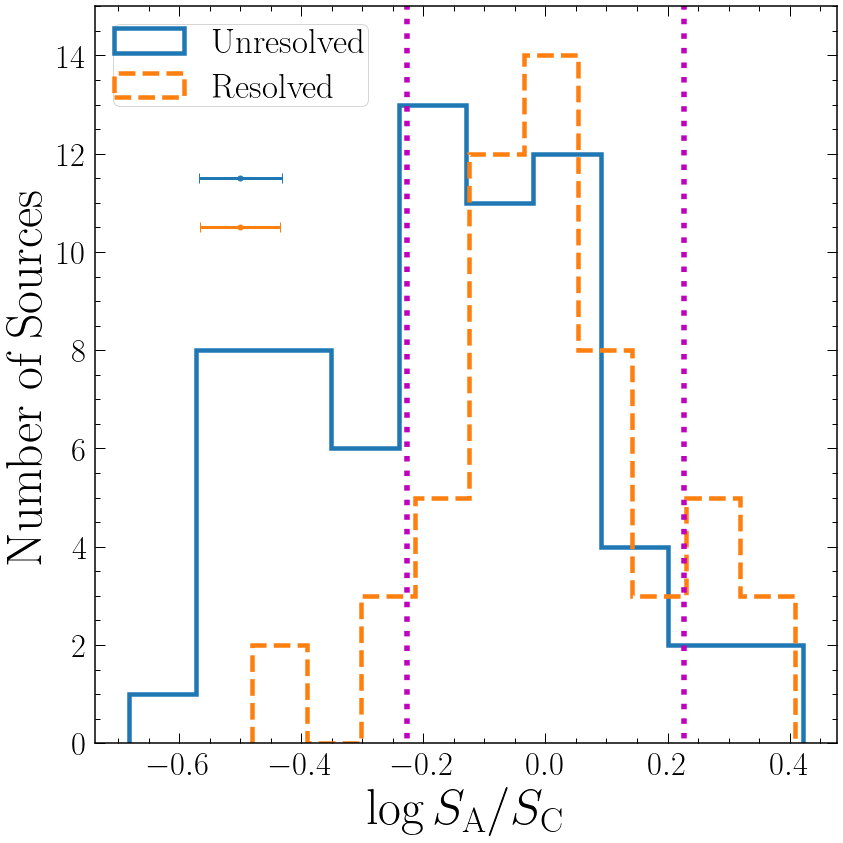

In [18]:
fig, ax = plt.subplots(figsize=(12,12))

ax.hist(log_ratio[U], histtype="step", linewidth=4.5, 
         ls="-", label="Unresolved")
ax.hist(log_ratio[(~U)&(~ND)], histtype="step", 
          linewidth=4.5, label="Resolved", ls="--")

ax.plot([-sigma,-sigma], [-.2,33.0], ":m", linewidth=5.5)
ax.plot([+sigma,+sigma], [-.2,33.0], ":m", linewidth=5.5)

#Add exemplary error bars
ax.errorbar(x=-0.5, y=11.5, xerr=mederrU, markersize=5, capsize=4.9, fmt="o", linewidth=3.0, color=mplcolors[0])
ax.errorbar(x=-0.5, y=10.5, xerr=mederrR, markersize=5, capsize=4.9, fmt="o", linewidth=3.0, color=mplcolors[1])

ax.set_xlabel("log\,$S_\mathrm{A}/S_\mathrm{C}$", fontsize=50)
ax.set_ylabel("Number of Sources", fontsize=50)
#ax.set_ylabel("number of sources", fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=32.5)
ax.legend(loc="upper left", prop={"size":35}, borderpad=0.05,labelspacing=0.3)
ax.set_ylim(0,15)

plt.tight_layout()
#plt.savefig("PaperPlots/fig8_bottompanel.pdf")
plt.show()

---

In [105]:
from matplotlib.ticker import PercentFormatter
from matplotlib.transforms import Bbox

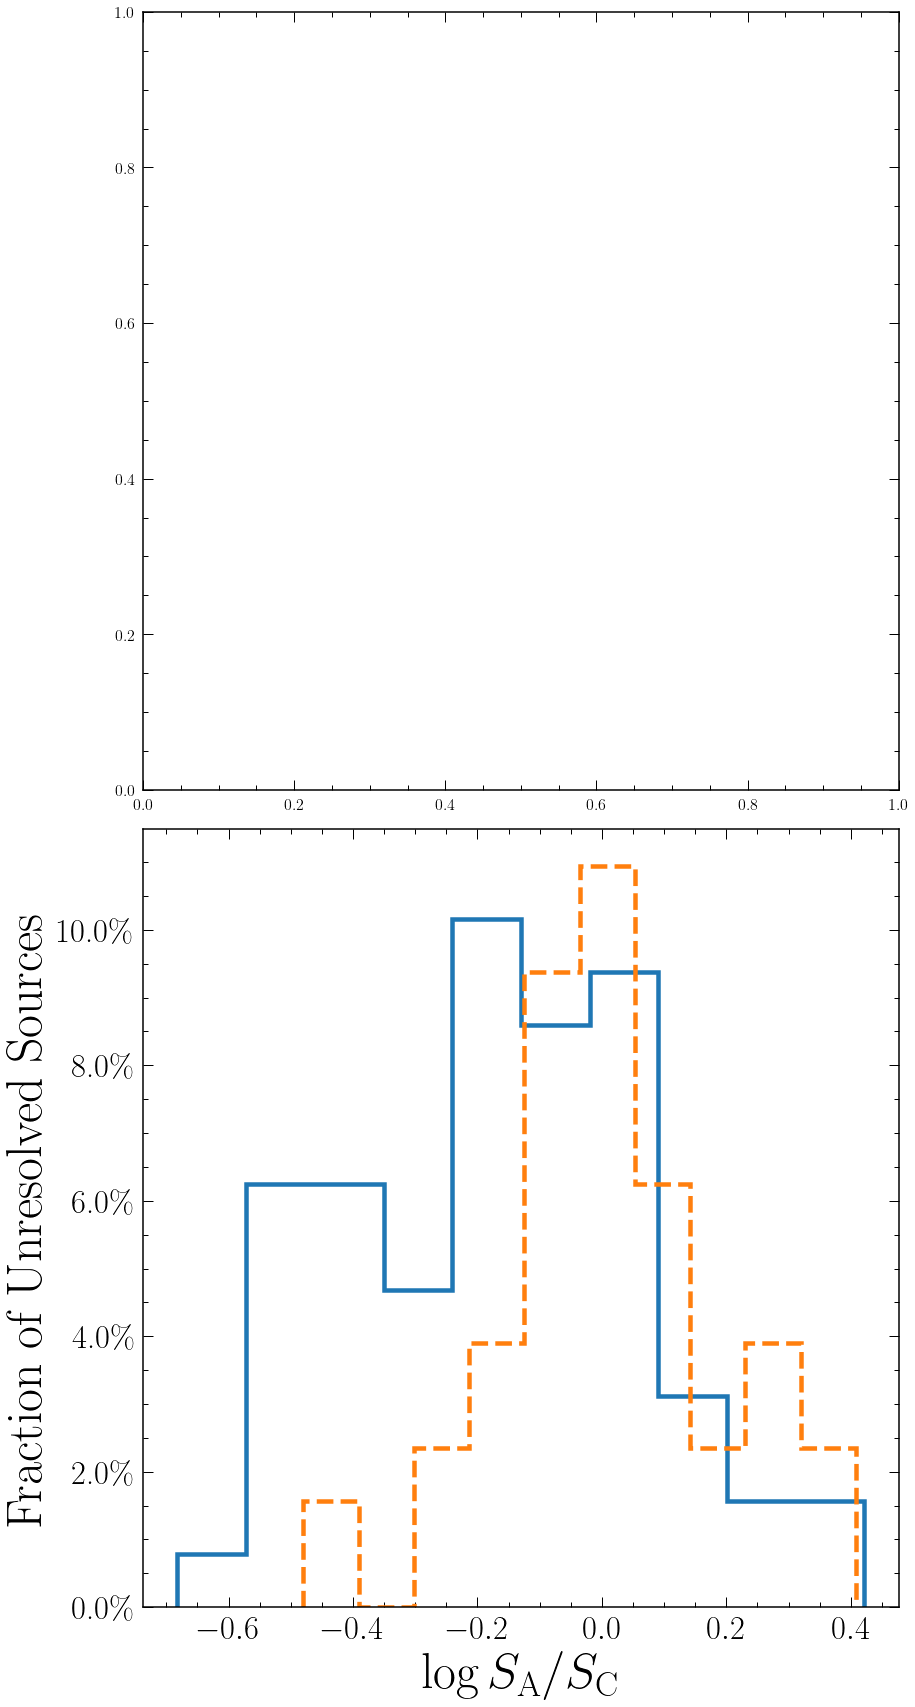

In [42]:
fig, [ax0, ax1] = plt.subplots(2, 1, figsize=(13,24))



######################

ax1.hist(log_ratio[U], histtype="step", linewidth=4.5, 
         ls="-", label="Unresolved", weights=np.ones(len(log_ratio[U])) / len(log_ratio))
ax1.hist(log_ratio[(~U)&(~ND)], histtype="step", 
          linewidth=4.5, label="Resolved", ls="--", weights=np.ones(len(log_ratio[(~U)&(~ND)])) / len(log_ratio))
ax1.tick_params(axis='both', labelsize=32.5)
#ax1.tick_params(axis='x', labelsize=32.5)
ax1.yaxis.set_major_formatter(PercentFormatter(1))

ax1.set_ylabel('Fraction of Unresolved Sources', fontsize=50)
ax1.set_xlabel("log\,$S_\mathrm{A}/S_\mathrm{C}$", fontsize=50)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator


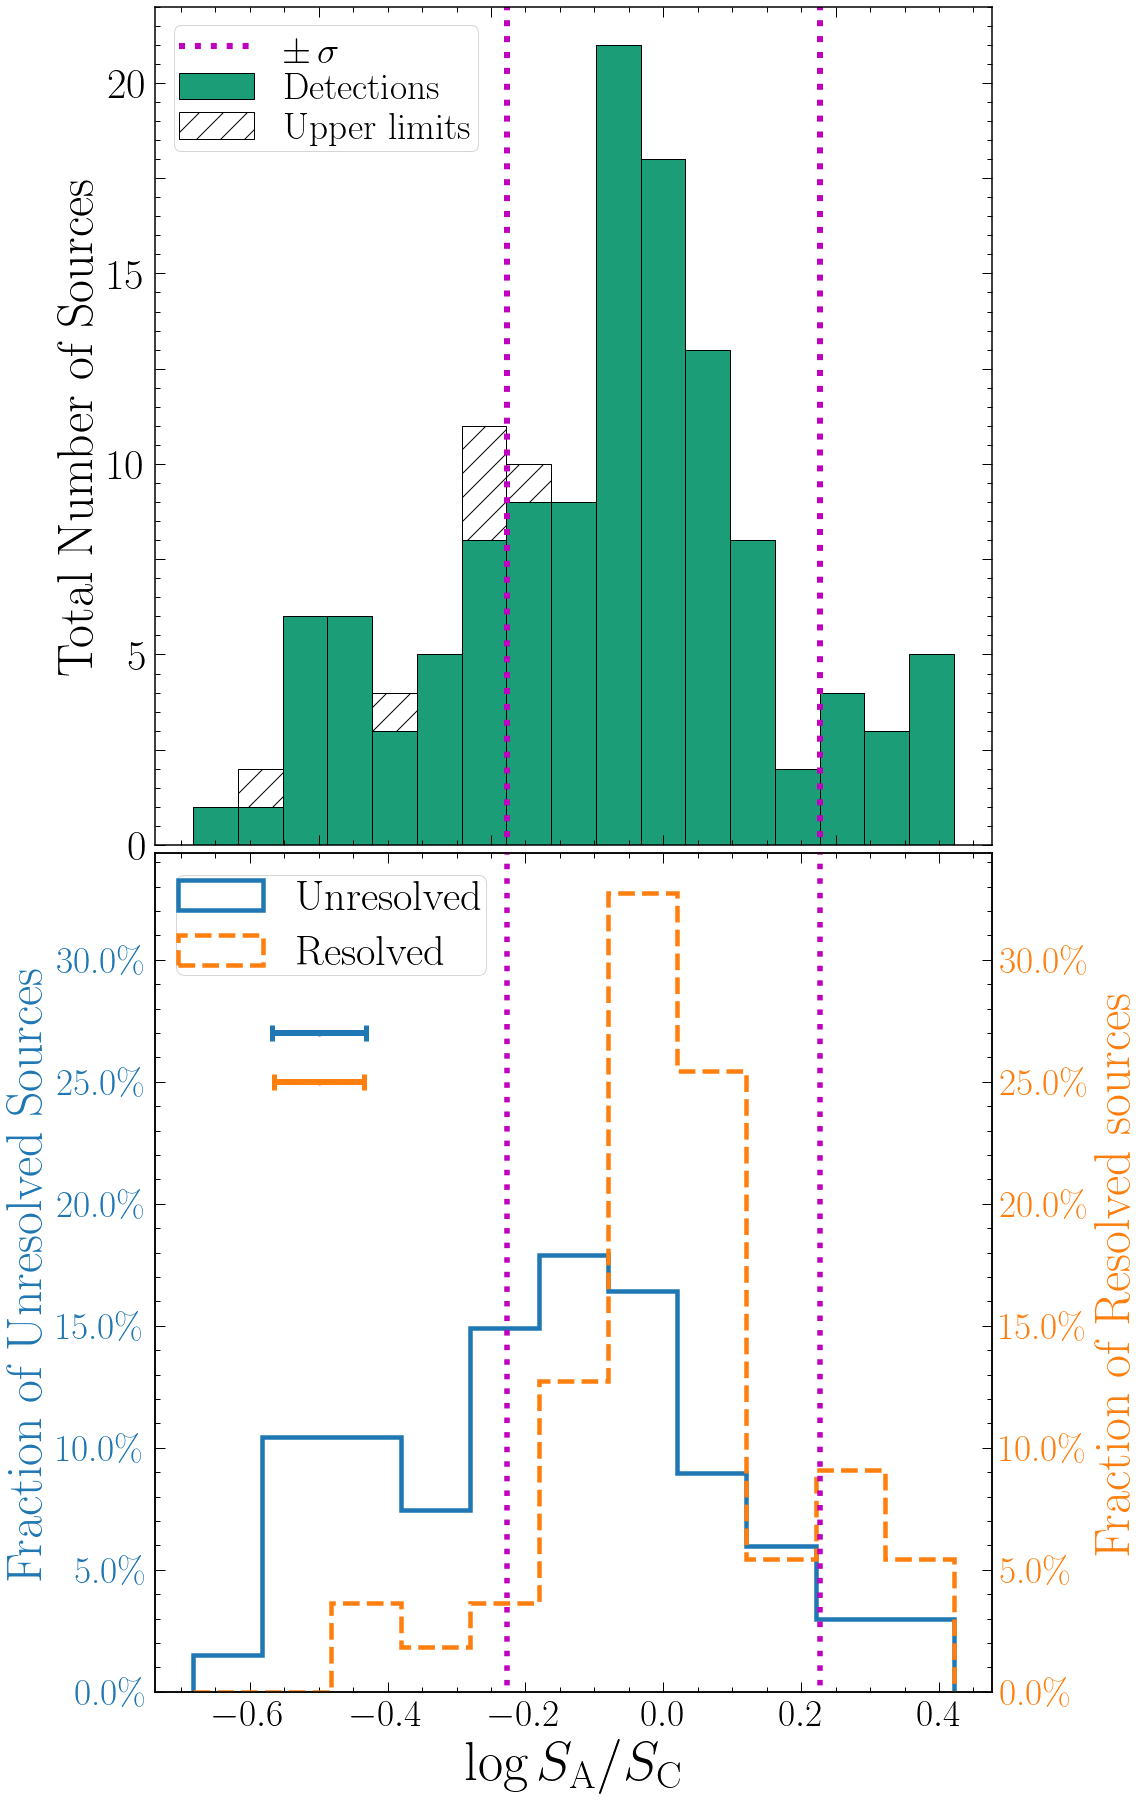

In [110]:
ratbins = np.linspace(min(log_ratio), max(log_ratio), 18)
ratbins2 = np.linspace(min(log_ratio[U]), max(log_ratio[U]), 12)

fig, [ax0, ax1] = plt.subplots(2, 1, figsize=(15,31))
plt.subplots_adjust(hspace=0.01)

n, bins, patches = ax0.hist([log_ratio[~ND],log_ratio[ND]], histtype="barstacked", 
                   edgecolor="k", color=[rplot.csdark[0], "w"], bins=ratbins, 
                   label=["Detections","Upper limits"])

#Need to do hatches manually since matplotlib doesn't
#let you separate them for separate data series
hatches = ['', '/']
for patch_set, hatch in zip(patches, hatches):
    for patch in patch_set.patches:
        patch.set_hatch(hatch)

ax0.plot([-sigma,-sigma], [-.2,33.0], ":m", linewidth=6.0, label="$\pm$\,$\sigma$")
ax0.plot([+sigma,+sigma], [-.2,33.0], ":m", linewidth=6.0)

#ax1.set_xlabel("log\,$X$", fontsize=50)
#ax1.set_ylabel("Number of Sources", fontsize=40)
ax0.set_ylabel('Total Number of Sources', fontsize=50)
ax0.tick_params(axis='both', which='major', labelsize=42.5)
ax0.legend(loc="upper left", prop={"size":37.5},frameon=True, borderpad=0.15,labelspacing=0.1)
ax0.set_ylim(0,22.)
ax0.set_xticklabels([])
ax0.set_yticklabels(["0","","5","","10","","15","","20"])
xlims = plt.gca().get_xlim()

###############################

color = 'tab:blue'
ax1.set_ylabel('Fraction of Unresolved Sources', color=color, fontsize=50)
_, _, h1 = ax1.hist(log_ratio[U], histtype="step", linewidth=4.5, 
         ls="-", label="Unresolved", color=color, bins=ratbins2, weights=np.ones(len(log_ratio[U])) / len(log_ratio[U]))
ax1.tick_params(axis='y', labelcolor=color, labelsize=37.5)
ax1.tick_params(axis='x', labelsize=37.5)
ax1.yaxis.set_major_formatter(PercentFormatter(1))

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:orange'
ax2.set_ylabel('Fraction of Resolved sources', color=color, fontsize=50)  # we already handled the x-label with ax1
_, _, h2 = ax2.hist(log_ratio[(~U)&(~ND)], histtype="step", 
          linewidth=4.5, label="Resolved", ls="--", color=color, bins=ratbins2, weights=np.ones(len(log_ratio[(~U)&(~ND)])) / len(log_ratio[(~U)&(~ND)]))
ax2.tick_params(axis='y', labelcolor=color, labelsize=37.5)
ax2.yaxis.set_major_formatter(PercentFormatter(1))
ylims = ax2.get_ylim()
ax2.plot([-sigma,-sigma], [-.2,33.0], ":m", linewidth=5.5)
ax2.plot([+sigma,+sigma], [-.2,33.0], ":m", linewidth=5.5)

ax2.errorbar(x=-0.5, y=0.27, xerr=mederrU, markersize=5, capsize=7.9, capthick=5, fmt="o", linewidth=6.0, color=mplcolors[0])
ax2.errorbar(x=-0.5, y=0.25, xerr=mederrR, markersize=5, capsize=7.9, capthick=5, fmt="o", linewidth=6.0, color=mplcolors[1])

ax1.set_ylim(ylims)
ax2.set_ylim(ylims)
ax1.set_xlabel("log\,$S_\mathrm{A}/S_\mathrm{C}$", fontsize=55)

histos = h1+h2
labs = [h.get_label() for h in histos]
ax2.legend(histos, labs, loc="upper left", prop={"size":42.5}, borderpad=0.05,labelspacing=0.3)

#fig.tight_layout()  # otherwise the right y-label is slightly clipped
#plt.savefig("PaperPlots/fluxratio_2panel.pdf", bbox_inches=Bbox([[-0.55,0],[15.7,31]]))
plt.show()

In [107]:
Bbox?

Make plot on radio distributions with same color scale

In [19]:
Sbins = np.logspace(np.log10(min(S6)), np.log10(max(S6)), 15)
Lbins = np.linspace(min(L6), max(L6_kell), 15)
Rbins = np.linspace(min(logR), max(logR), 15) #one is ~ -10

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


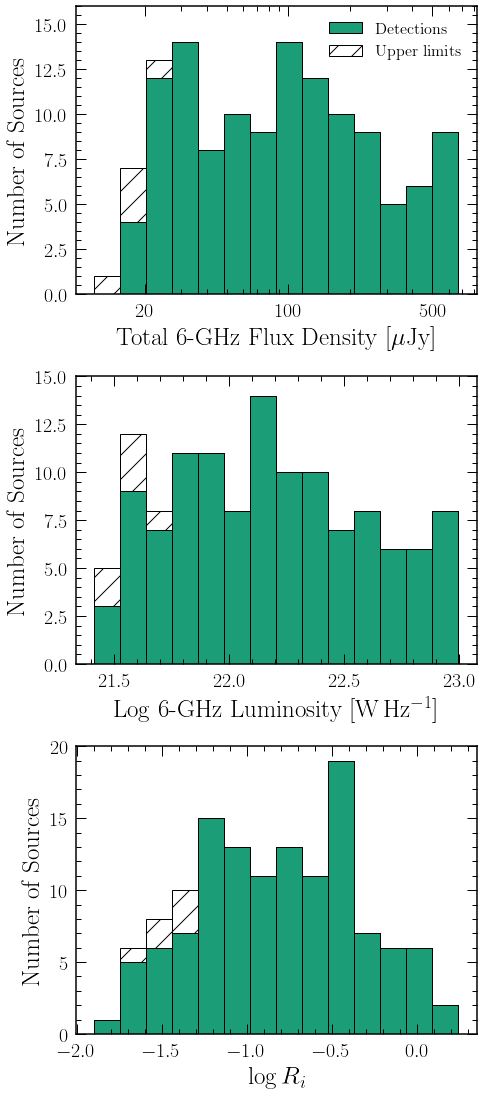

In [20]:
import matplotlib

fig, [ax1,ax2,ax3] = plt.subplots(3, 1, figsize=(7,15.5))

n, bins, patches = ax1.hist([S6[~ND],S6[ND]], histtype="barstacked", 
                   edgecolor="k", color=[rplot.csdark[0], "w"], bins=Sbins, 
                   label=["Detections","Upper limits"])

#Need to do hatches manually since matplotlib doesn't
#let you separate them for separate data series
hatches = ['', '/']
for patch_set, hatch in zip(patches, hatches):
    for patch in patch_set.patches:
        patch.set_hatch(hatch)
        
ax1.set_xscale("log")
ax1.set_xticks([20, 100, 500])
ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax1.set_xlabel("Total 6-GHz Flux Density [$\mu$Jy]", fontsize=25)
ax1.set_ylabel("Number of Sources", fontsize=25)
ax1.set_ylim(0,16)
ax1.legend(loc="upper right", prop={"size":16.25}, frameon=False)


n, bins, patches = ax2.hist([L6[~ND],L6[ND]], histtype="barstacked", 
                   edgecolor="k", color=[rplot.csdark[0], "w"], bins=Lbins, 
                   label=["Detections","Upper limits"])

#Need to do hatches manually since matplotlib doesn't
#let you separate them for separate data series
hatches = ['', '/']
for patch_set, hatch in zip(patches, hatches):
    for patch in patch_set.patches:
        patch.set_hatch(hatch)
        
ax2.set_xlabel("Log 6-GHz Luminosity [W\,Hz$^{-1}$]", fontsize=25)
ax2.set_ylabel("Number of Sources", fontsize=25)
ax2.set_ylim(0,15)
#ax2.legend(loc="upper right", prop={"size":18.5}, frameon=False)


n, bins, patches = ax3.hist([logR[~ND],logR[ND]], histtype="barstacked", 
                   edgecolor="k", color=[rplot.csdark[0], "w"], bins=Rbins, 
                   label=["Detections","Upper limits"])

#Need to do hatches manually since matplotlib doesn't
#let you separate them for separate data series
hatches = ['', '/']
for patch_set, hatch in zip(patches, hatches):
    for patch in patch_set.patches:
        patch.set_hatch(hatch)
        
ax3.set_xlabel("log\,$R_i$", fontsize=25)
ax3.set_ylabel("Number of Sources", fontsize=25)
ax3.set_ylim(0,20)
#ax3.legend(loc="upper right", prop={"size":22.5})

ax1.tick_params(axis='both', which='major', labelsize=20)
ax2.tick_params(axis='both', which='major', labelsize=20)
ax3.tick_params(axis='both', which='major', labelsize=20)

plt.tight_layout()
plt.savefig("PaperPlots/radio_distributions.pdf")
plt.show()

----

Amy and I met yesterday 9/14/2020 and she suggested that a nice version of this plot would be a sort of scatter version that takes the uncertainties of individual sources into account.  Then we could display the errors of the ratio between flux densities easily and see which changes are within that of the measurement uncertainties.

In [21]:
df

,Name,Maj,Min,S1p4_FIRST,S1p4_err,A_morph,C_morph,Flux,FluxErr,PFimfit,...,logL,i,I_2a,MI_Z2,LOGL2500,R,LD_cm,Kell_Ratio,logL6GHz [W/Hz],MJD_dr7
0,0808+4407,472.0,237.0,NaN,NaN,U,U,36.3,8.300000,36.3,...,22.12,17.615,-22.58,-23.605438,29.601365,0.19,4.389983e+27,0.6,21.901570,NaN
1,0816+4258,153.0,105.0,NaN,NaN,SR,U,199.0,14.000000,178.5,...,22.54,16.636,-23.21,-23.978752,29.750691,0.29,3.651811e+27,0.9,22.485202,NaN
2,0822+4553,150.0,89.0,427,127.0,M,U,531.0,33.015148,425.0,...,22.77,17.695,-22.69,-23.688601,29.634631,0.73,4.852865e+27,2.4,23.151097,51868.0
3,0834+3826,238.0,39.0,NaN,NaN,U,U,116.8,7.100000,116.8,...,22.49,17.527,-22.77,-23.800290,29.679306,0.36,4.629499e+27,0.9,22.453822,NaN
4,0843+5357,838.0,168.0,516,150.0,E,U,349.0,31.000000,122.8,...,22.72,16.440,-23.25,-23.912282,29.724103,0.43,3.371040e+27,0.9,22.661519,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,1630+4711,448.0,27.0,NaN,NaN,U,U,33.9,5.600000,33.9,...,22.12,16.910,-23.25,-24.232540,29.852206,0.10,4.298551e+27,0.5,21.854134,NaN
124,1631+4048,0.0,0.0,NaN,NaN,U,U,26.6,4.600000,26.6,...,21.97,17.094,-22.96,-23.884491,29.712987,0.09,4.080699e+27,0.5,21.704976,NaN
125,1631+2953,0.0,0.0,NaN,NaN,U,U,67.6,5.700000,67.6,...,22.35,16.707,-23.32,-24.207522,29.842199,0.17,4.008582e+27,0.5,22.095001,NaN
126,1703+1910,0.0,0.0,NaN,NaN,ND,U,11.4,0.000000,11.4,...,21.71,17.203,-23.11,-24.171656,29.827853,0.04,4.666576e+27,0.5,21.449994,NaN


In [22]:
#This was an errant object I fixed
df.loc[np.argmin(ratio)], ratio[np.argmin(ratio)]

(Name                                    1005+4230
 Maj                                           0.0
 Min                                           0.0
 S1p4_FIRST                                    NaN
 S1p4_err                                      NaN
                                 ...              
 R                                            0.16
 LD_cm              4062646052262780193539620864.0
 Kell_Ratio                                    0.2
 logL6GHz [W/Hz]                         21.651103
 MJD_dr7                                       NaN
 Name: 27, Length: 75, dtype: object,
 0.20789473684210527)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


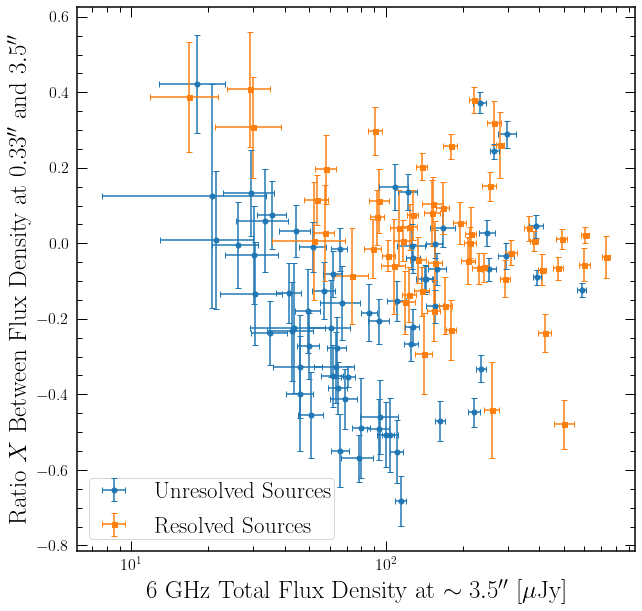

In [23]:
fig = plt.figure(figsize=(10,10))

plt.errorbar(x=S6_kell[U], y=log_ratio[U], xerr=Cerr[U], yerr=log_err[U], 
             markersize=5, capsize=2.8, fmt="o", label="Unresolved Sources")
plt.errorbar(x=S6_kell[(~U)&(~ND)], y=log_ratio[(~U)&(~ND)], xerr=Cerr[(~U)&(~ND)], 
             yerr=log_err[(~U)&(~ND)], markersize=5, capsize=2.8, fmt="s", label="Resolved Sources")

#plt.yscale("log")
plt.xscale("log")
plt.xlabel("6 GHz Total Flux Density at $\sim3.5''$ [$\mu$Jy]", fontsize=25)
plt.ylabel("Ratio $X$ Between Flux Density at $0.33''$ and $3.5''$", fontsize=25)
plt.legend(loc="lower left", prop={"size": 23}, borderpad=0.1)

A source is interesting if its distance from $10^0$ is greater than its error

In [24]:
from matplotlib.transforms import Bbox

<ipython-input-34-e02c2cf23539>:59: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax_scatter.set_xlim(xlims)
<ipython-input-34-e02c2cf23539>:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


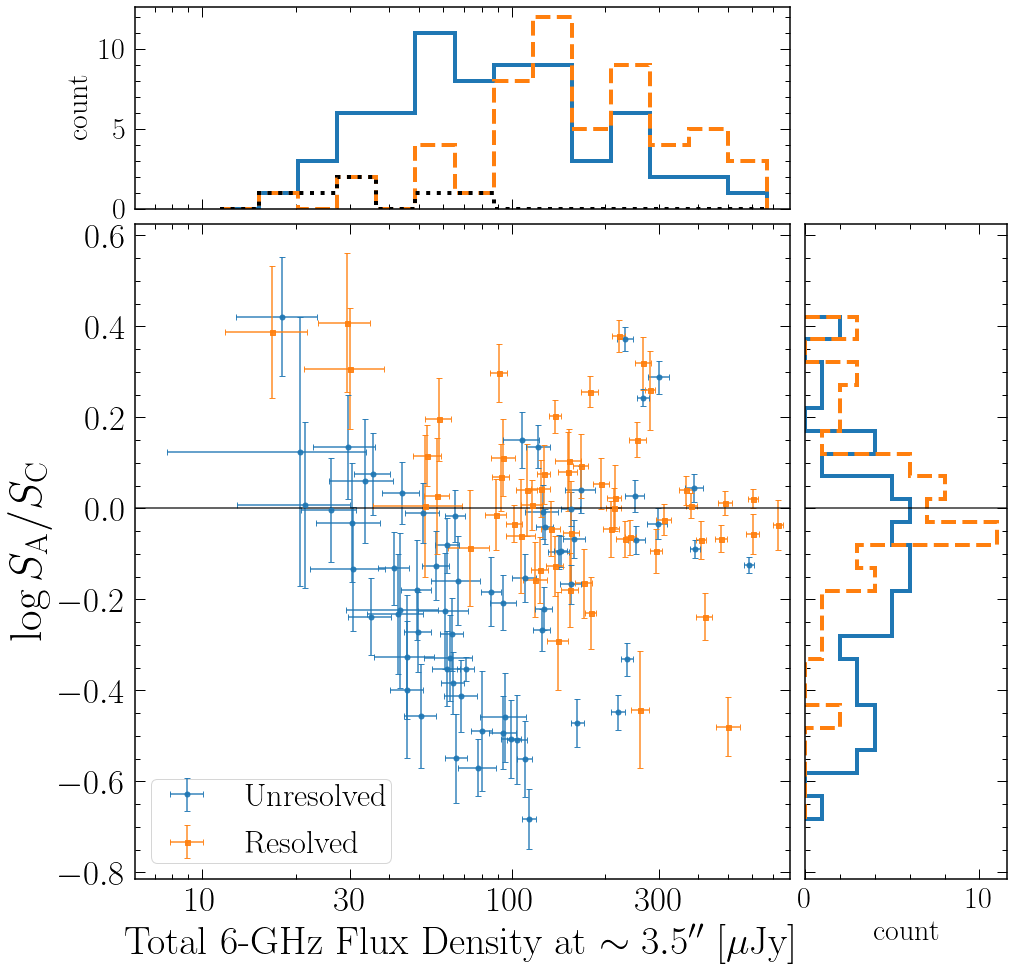

In [34]:
#ratbins = np.linspace(min(ratio), max(ratio), 21)

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.015


rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a rectangular Figure
plt.figure(figsize=(14, 14))

ax_scatter = plt.axes(rect_scatter)
ax_scatter.tick_params(direction='in', top=True, right=True)
ax_histx = plt.axes(rect_histx)
ax_histx.tick_params(direction='in', labelbottom=False)
ax_histy = plt.axes(rect_histy)
ax_histy.tick_params(direction='in', labelleft=False)


#Plot scatter data
ax_scatter.errorbar(x=S6_kell[U], y=log_ratio[U], xerr=Cerr[U], yerr=log_err[U], 
             markersize=5, alpha=0.9, capsize=2.8, fmt="o", label="Unresolved")
ax_scatter.errorbar(x=S6_kell[(~U)&(~ND)], y=log_ratio[(~U)&(~ND)], xerr=Cerr[(~U)&(~ND)], 
             yerr=log_err[(~U)&(~ND)], markersize=5, alpha=0.9, capsize=2.8, fmt="s", label="Resolved")

xlims = ax_scatter.get_xlim() #Save limits before plotting
ax_scatter.plot([0,10**3], [0,0], "-k", alpha=0.8)

#Plot x axis distribution
ax_histx.hist(S6_kell[U],bins=Sbins,align='mid', histtype="step", linewidth=4.0)
ax_histx.hist(S6_kell[(~U)&(~ND)],bins=Sbins,align='mid', histtype="step", linewidth=4.0, ls="--")
ax_histx.hist(S6_kell[ND],bins=Sbins,align='mid', histtype="step", linewidth=4.0, ls=":", color="k")
ax_histx.set_ylabel('count', fontsize=30)
ax_histx.tick_params(axis='both', which='major', labelsize=30)

ax_histy.hist(log_ratio[U],bins=ratbins,orientation='horizontal',align='mid',
              histtype="step", linewidth=4.0)
ax_histy.hist(log_ratio[(~U)&(~ND)],bins=ratbins,orientation='horizontal',align='mid',
              histtype="step", linewidth=4.0, linestyle="--")
#ax_histy.hist(log_ratio[ND],bins=ratbins,orientation='horizontal',align='mid',
#              histtype="step", linewidth=4.0, linestyle=":", color="k")
histy_xlims = ax_histy.get_xlim()
ax_histy.plot([0,20], [0,0], "-k", alpha=0.8)
ax_histy.set_xlabel('count', fontsize=30)
ax_histy.tick_params(axis='both', which='major', labelsize=30)

ax_scatter.set_xlabel(r"Total 6-GHz Flux Density at $\sim3.5''$ [$\mu$Jy]", fontsize=40)
ax_scatter.set_ylabel("$\log{S_\mathrm{A}/S_\mathrm{C}}$", fontsize=45)
ax_scatter.legend(loc="lower left", prop={"size": 32.5}, borderpad=0.1)
#ax_scatter.set_xlim(22.40, 25.07)
ax_scatter.tick_params(axis='both', which='major', labelsize=35)
ax_scatter.set_xscale("log")
#ax_scatter.set_yscale("log")
ax_scatter.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax_scatter.set_xlim(xlims)
ax_scatter.set_xticks([10,30,100,300])

ax_histx.set_xlim(ax_scatter.get_xlim())
ax_histy.set_ylim(ax_scatter.get_ylim())
ax_histy.set_xlim(histy_xlims)
ax_histx.set_xscale("log")
#ax_histy.set_yscale("log")
plt.tight_layout()
plt.savefig("PaperPlots/fluxratioscat_whistos.pdf", bbox_inches=Bbox([[-0.5,0],[14,14]]))
plt.show()

There's the figure; now we ask:  

* What number of resolved/unresolved sources are farther away from unity than their error?

* How do these counts compare at different ends of the distribution?

In [23]:
ratio.shape,ratio, ratioerr.shape,ratioerr

((128,),
 array([0.59508197, 0.85775862, 2.39189189, 0.9125    , 0.85121951,
        2.44047619, 1.81785714, 0.9       , 0.69402985, 0.4       ,
        0.57834758, 0.65581395, 0.6015748 , 1.56896552, 0.44366197,
        0.87853577, 0.6212766 , 0.68129032, 0.74912281, 1.29361702,
        0.70272727, 0.36153846, 0.99612903, 2.64088398, 0.51506024,
        2.36008584, 0.57857143, 0.20789474, 0.31162325, 1.02653061,
        1.01860465, 1.09589041, 2.02675585, 1.33333333, 2.55972696,
        0.67005076, 1.01637931, 1.80558659, 1.13333333, 0.69747899,
        0.73529412, 0.38719068, 0.90298507, 1.36271186, 0.99233716,
        0.3215812 , 0.33133733, 0.66233766, 0.8028169 , 1.36721311,
        1.98237885, 1.30524345, 0.80546075, 1.0513245 , 0.88461538,
        0.66194332, 0.59677419, 1.0046729 , 0.41421947, 0.86915888,
        1.18767507, 0.5106383 , 0.68421053, 0.75187713, 0.81352041,
        0.94516129, 0.44480519, 0.86363636, 2.08270677, 1.10483871,
        1.17136659, 1.0636    , 0.46610

In [24]:
#Condition for source to be significant
flag = (abs(log_ratio)>3*log_err)

In [25]:
print("Total sources offset from unity: {}".format(flag.sum()))
print("Unresolved source count        : {}".format(flag[U].sum()))
print("Resolved source count          : {}".format(flag[~U&~ND].sum()))

Total sources offset from unity: 43
Unresolved source count        : 30
Resolved source count          : 9


So 43/128 sources are offset from unity by values greater than just their uncertainties and the number of unresolved is higher than resolved.  Makes sense since it isn't just variability causing changes in the fainter unresolved sources -- we're also filtering out some emission

In [26]:
inc = (flag&(log_ratio>0.))
dec = (flag&(log_ratio<0.))

print("Number of sources increased in flux density: {}".format(inc.sum()))
print("Unresolved source count                    : {}".format(inc[U].sum()))
print("Resolved source count                      : {}\n".format(inc[~U&~ND].sum()))

print("Number of sources decreased in flux density: {}".format(dec.sum()))
print("Unresolved source count                    : {}".format(dec[U].sum()))
print("Resolved source count                      : {}".format(dec[~U&~ND].sum()))

Number of sources increased in flux density: 10
Unresolved source count                    : 4
Resolved source count                      : 6

Number of sources decreased in flux density: 33
Unresolved source count                    : 26
Resolved source count                      : 3


#### Question:  What percentage of sources are Unresolved and have flux density consistent with their C-configuration measurement?  Cite this number in the summary of the paper.

67 sources are Unresolved.

30 of these sources have flux densities inconsistent with their previous measurement.

22 likely have extended emission; there are 26 that decreased and 4 that increased.

So there are 67-22=45/128=**0.352** sources with emission confined to a single component.

In [27]:
45/128

0.3515625

In [28]:
sdss_names[inc]

array(['0822+4553', '0952+2051', '1000+1047', '1045+2933', '1146+3715',
       '1235+4104', '1425+0803', '1444+0633', '1617+0638', '1627+4736'],
      dtype=object)

In [29]:
#Loop through flagged objects to create output needed for paper
mask = (inc&~U&~ND)
#mask = (dec&~U&~ND)
#mask = (inc&U)
#mask = (dec&U)

for i in S6_kell[mask].argsort():
    print("& & J%s & $%.2f\pm%.2f$ & %3d & R-%s \\\\" % (sdss_names[mask][i], log_ratio[mask][i], \
                                           log_err[mask][i], S6_kell[mask][i], A_morph[mask][i]))

& & J1146+3715 & $0.30\pm0.06$ &  90 & R-M \\
& & J1425+0803 & $0.20\pm0.04$ & 138 & R-SR \\
& & J1045+2933 & $0.26\pm0.03$ & 179 & R-M \\
& & J0822+4553 & $0.38\pm0.03$ & 222 & R-M \\
& & J1444+0633 & $0.15\pm0.04$ & 255 & R-E \\
& & J1235+4104 & $0.32\pm0.06$ & 266 & R-E \\


In [30]:
S6_kell[mask].argsort()

array([2, 4, 1, 0, 5, 3])

Ah, that's great that the counts of increased/decreased resolved sources agree pretty well with each other.  Now I want to know the difference between % of sources that increased/decreased for the unresolved/resolved sources. 

In [31]:
print("Percent of sample that increased: {:.2f}%".format(100.*inc.sum()/128.))
print("Percent that was resolved       : {:.2f}%".format(100.*inc[~U&~ND].sum()/128.))
print("Percent that was unresolved     : {:.2f}%\n".format(100.*inc[U|ND].sum()/128.))



print("Percent of sample that decreased: {:.2f}%".format(100.*dec.sum()/128.))
print("Percent that was resolved       : {:.2f}%".format(100.*dec[~U&~ND].sum()/128.))
print("Percent that was unresolved     : {:.2f}%".format(100.*dec[U|ND].sum()/128.))

Percent of sample that increased: 7.81%
Percent that was resolved       : 4.69%
Percent that was unresolved     : 3.12%

Percent of sample that decreased: 25.78%
Percent that was resolved       : 2.34%
Percent that was unresolved     : 23.44%


Let's assume the distribution for the resolved sources is symmetric about unity (seems to be within reasonable measurement error); that then leaves us with the unresolved sources of the sample.  

$6.45\%$ of the total sample is unresolved and increased in flux density; this must be due to variability.  Variability has the same effect in both directions, so if no emission was being resolved out, we might expect the percent of unresolved sources in our sample that decreased in flux density to roughly agree.  However, there's actually a big difference!  We might then say there are at least $36.29\%-6.45\%\approx30\%$ of our sources that have decreased due to the resolution of our follow up observations, then say possible causes.

I paused as I was writing the above since I thought the fact that the number of unresolved sources that increased was much lower than the resolved sources meant something went wrong ... but then realized that could be an indication that these sources are less likely to be variable (which would indicate SF!)

### Grey out the sources with $X=1$

In [32]:
ratbins = np.linspace(min(flux_ratio), max(flux_ratio), 21)

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005


rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a rectangular Figure
plt.figure(figsize=(14, 14))

ax_scatter = plt.axes(rect_scatter)
ax_scatter.tick_params(direction='in', top=True, right=True)
ax_histx = plt.axes(rect_histx)
ax_histx.tick_params(direction='in', labelbottom=False)
ax_histy = plt.axes(rect_histy)
ax_histy.tick_params(direction='in', labelleft=False)


#Plot scatter data
ax_scatter.errorbar(x=S6_kell[U&(inc|dec)], y=ratio[U&(inc|dec)], xerr=Cerr[U&(inc|dec)], yerr=ratioerr[U&(inc|dec)], 
             markersize=5, alpha=0.9, capsize=2.8, fmt="o", label="Unresolved")
ax_scatter.errorbar(x=S6_kell[(~U)&(~ND)&(inc|dec)], y=ratio[(~U)&(~ND)&(inc|dec)], xerr=Cerr[(~U)&(~ND)&(inc|dec)], 
             yerr=ratioerr[(~U)&(~ND)&(inc|dec)], markersize=5, alpha=0.9, capsize=2.8, fmt="s", label="Resolved")

#X=1 data
ax_scatter.errorbar(x=S6_kell[U&~(inc|dec)], y=ratio[U&~(inc|dec)], xerr=Cerr[U&~(inc|dec)], yerr=ratioerr[U&~(inc|dec)], 
                    markersize=5, alpha=0.15, capsize=2.8, fmt="o", color="grey")
ax_scatter.errorbar(x=S6_kell[(~U)&(~ND)&~(inc|dec)], y=ratio[(~U)&(~ND)&~(inc|dec)], xerr=Cerr[(~U)&(~ND)&~(inc|dec)], 
                    yerr=ratioerr[(~U)&(~ND)&~(inc|dec)], markersize=5, alpha=0.15, capsize=2.8, fmt="s", color="grey")

xlims = ax_scatter.get_xlim() #Save limits before plotting
ax_scatter.plot([0,10**3], [1,1], "-k", alpha=0.8)

ax_scatter.set_xscale("log")
ax_scatter.set_yscale("log")
ax_scatter.set_xlim(xlims)
ax_scatter.tick_params(axis='both', which='major', labelsize=25)


#Plot x axis distribution
ax_histx.hist(S6_kell[U],bins=Sbins,align='mid', histtype="step", linewidth=4.0)
ax_histx.hist(S6_kell[(~U)&(~ND)],bins=Sbins,align='mid', histtype="step", linewidth=4.0, ls="--")
ax_histx.set_ylabel('count', fontsize=27.5)
ax_histx.tick_params(axis='both', which='major', labelsize=25)

ax_histy.hist(ratio[U],bins=10.**ratbins,orientation='horizontal',align='mid',
              histtype="step", linewidth=4.0)
ax_histy.hist(ratio[(~U)&(~ND)],bins=10.**ratbins,orientation='horizontal',align='mid',
              histtype="step", linewidth=4.0, linestyle="--")
histy_xlims = ax_histy.get_xlim()
ax_histy.plot([0,20], [1,1], "-k", alpha=0.8)
ax_histy.set_xlabel('count', fontsize=27.5)
ax_histy.tick_params(axis='both', which='major', labelsize=25)

ax_scatter.set_xlabel("Total 6-GHz Flux Density at $\sim3.5''$ [$\mu$Jy]", fontsize=35)
ax_scatter.set_ylabel("Flux Density Ratio $S_\mathrm{A}/S_\mathrm{C}$", fontsize=35)
ax_scatter.legend(loc="lower left", prop={"size": 32.5}, borderpad=0.1)
#ax_scatter.set_xlim(22.40, 25.07)
ax_scatter.tick_params(axis='both', which='major', labelsize=30)

ax_histx.set_xlim(ax_scatter.get_xlim())
ax_histy.set_ylim(ax_scatter.get_ylim())
ax_histy.set_xlim(histy_xlims)
ax_histx.set_xscale("log")
ax_histy.set_yscale("log")
plt.tight_layout()
plt.savefig("PaperPlots/fluxratioscat_whistos_greyed_out.pdf")
plt.show()

NameError: name 'flux_ratio' is not defined

In [ ]:
len(ratio)

In [ ]:
Lbins

In [ ]:
#for errors, consider detections separately; errors change logarithmically
fracerr = Cerr/S6_kell #turn fractional uncertainty into a variable
LC_uplim = np.log10(1+fracerr)
LC_lolim = abs(np.log10(1-fracerr))
LCerr = np.array([LC_lolim, LC_uplim])

### L6 on x-axis

In [ ]:
ratbins = np.linspace(min(flux_ratio), max(flux_ratio), 21)

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005


rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a rectangular Figure
plt.figure(figsize=(14, 14))

ax_scatter = plt.axes(rect_scatter)
ax_scatter.tick_params(direction='in', top=True, right=True)
ax_histx = plt.axes(rect_histx)
ax_histx.tick_params(direction='in', labelbottom=False)
ax_histy = plt.axes(rect_histy)
ax_histy.tick_params(direction='in', labelleft=False)


#Plot scatter data
ax_scatter.errorbar(x=L6_kell[U], y=ratio[U], xerr=LCerr[:,U], yerr=ratioerr[U], 
             markersize=5, alpha=0.9, capsize=2.8, fmt="o", label="Unresolved")
ax_scatter.errorbar(x=L6_kell[(~U)&(~ND)], y=ratio[(~U)&(~ND)], xerr=LCerr[:,(~U)&(~ND)], 
             yerr=ratioerr[(~U)&(~ND)], markersize=5, alpha=0.9, capsize=2.8, fmt="s", label="Resolved")

xlims = ax_scatter.get_xlim() #Save limits before plotting
ax_scatter.plot([0,10**3], [1,1], "-k", alpha=0.8)

#ax_scatter.set_xscale("log")
ax_scatter.set_yscale("log")
ax_scatter.set_xlim(xlims)
ax_scatter.tick_params(axis='both', which='major', labelsize=25)


#Plot x axis distribution
ax_histx.hist(L6_kell[U],bins=Lbins,align='mid', histtype="step", linewidth=4.0)
ax_histx.hist(L6_kell[(~U)&(~ND)],bins=Lbins,align='mid', histtype="step", linewidth=4.0, ls="--")
ax_histx.set_ylabel('count', fontsize=27.5)
ax_histx.tick_params(axis='both', which='major', labelsize=25)

ax_histy.hist(ratio[U],bins=10.**ratbins,orientation='horizontal',align='mid',
              histtype="step", linewidth=4.0)
ax_histy.hist(ratio[(~U)&(~ND)],bins=10.**ratbins,orientation='horizontal',align='mid',
              histtype="step", linewidth=4.0, linestyle="--")
histy_xlims = ax_histy.get_xlim()
ax_histy.plot([0,20], [1,1], "-k", alpha=0.8)
ax_histy.set_xlabel('count', fontsize=27.5)
ax_histy.tick_params(axis='both', which='major', labelsize=25)

ax_scatter.set_xlabel("Total 6-GHz Luminosity at $\sim3.5''$ [W\,Hz$^{-1}$]", fontsize=35)
ax_scatter.set_ylabel("Flux Density Ratio $X$", fontsize=35)
ax_scatter.legend(loc="lower left", prop={"size": 32.5}, borderpad=0.1)
#ax_scatter.set_xlim(22.40, 25.07)
ax_scatter.tick_params(axis='both', which='major', labelsize=30)

ax_histx.set_xlim(ax_scatter.get_xlim())
ax_histy.set_ylim(ax_scatter.get_ylim())
ax_histy.set_xlim(histy_xlims)
#ax_histx.set_xscale("log")
ax_histy.set_yscale("log")
plt.tight_layout()
plt.savefig("PaperPlots/fluxratioscat_whistos.pdf")
plt.show()

In [ ]:
LCerr[:,U].shape